# Paper Use Cases
In this notebook, we plot use cases for the MOSAD paper.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import sys
sys.path.append("../")

from tqdm import tqdm

In [3]:
from src.utils import load_mosad_dataset

Let's load the MOSAD dataset.

In [4]:
df_mosad = load_mosad_dataset()
df_mosad.head()

,dataset,routine,subject,sensor,sample_rate,change_points,activities,time_series
0,Routine1_Subject1_X-Acc,1,1,X-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.1986, -0.454326, -0.5473, -0.496056, -0.48..."
1,Routine1_Subject1_X-Gyro,1,1,X-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[0.0174, 0.0358, 0.0431, 0.0358, 0.0168, 0.008..."
2,Routine1_Subject1_X-Mag,1,1,X-Mag,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-31.02, -30.84, -30.65, -30.58, -31.52, -30.7..."
3,Routine1_Subject1_Y-Acc,1,1,Y-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.0161, -0.100877, -0.1434, -0.13972, -0.081..."
4,Routine1_Subject1_Y-Gyro,1,1,Y-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.0525, -0.0568, -0.0482, -0.0012, 0.0153, 0..."


Let's load the profiles from the best-performing methods ClaSP and FLOSS for a selected TS.

In [5]:
competitors = ["ClaSP", "FLOSS"]
methods = list()
selection = 94

for candidate_name in competitors:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))
    
converters = {
    "profile" : lambda profile: np.array(eval(profile.replace("inf", "1")), dtype=np.float64),
    "found_cps" : lambda found_cps: np.array(eval(found_cps), dtype=np.int64)
}

records = []

for idx, (name, file_name) in enumerate(methods):
    df = pd.read_csv(f"../experiments/{file_name}", usecols=["dataset", "profile", "found_cps"], converters=converters, compression="gzip")
    row = df.iloc[selection,:]
    records.append((name, row.profile, row.found_cps))

Let's plot the selected TS and the corresponding profiles.

In [6]:
row = df_mosad.iloc[selection,:]
ts, true_cps = row.time_series, row.change_points

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_38658/2006311767.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels([f"{int(x/50)}s" for x in axes[2].get_xticks()])


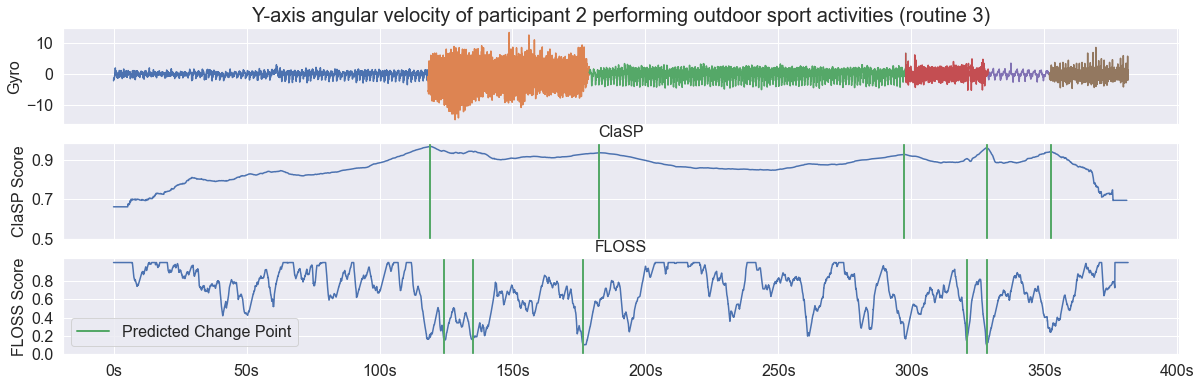

In [7]:
fontsize = 16

fig, axes = plt.subplots(
    3,  
    sharex=True, 
    gridspec_kw={'hspace': .2}, 
    figsize=(20,3 * 2)
)

axes[0].set_title("Y-axis angular velocity of participant 2 performing outdoor sport activities (routine 3)", fontsize=20)
axes[0].set_ylabel(f"Gyro", fontsize=fontsize)

segments = [0] + true_cps.tolist() + [len(ts)]

for idx in np.arange(0, len(segments)-1):
    axes[0].plot(np.arange(segments[idx], segments[idx+1]), ts[segments[idx]:segments[idx+1]])

for ax, (algorithm, profile, found_cps) in zip(axes[1:], records):
    ax.set_title(algorithm, fontsize=fontsize)
    ax.plot(np.arange(profile.shape[0]), np.clip(profile, 0, 1), color='b')

    for idx, found_cp in enumerate(found_cps):
        ax.axvline(x=found_cp, linewidth=2, color='g', label='Predicted Change Point' if idx == 0 else None)
        
    ax.set_ylabel(f"{algorithm} Score", fontsize=fontsize)
    
    ax.set_yticks(np.arange(max(0, np.round(profile.min(), 1)-.2),min(1, np.round(profile.max(), 1) +.2),.2))
    
axes[2].legend(prop={'size': fontsize})
axes[2].set_xticklabels([f"{int(x/50)}s" for x in axes[2].get_xticks()])

for ax in axes:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/comparative_detection_usecase.pdf", bbox_inches="tight")